In [1]:
import pandas as pd

In [2]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=e3470268878bf1cd9bf3af68487fcb8a690e4d2410aba7c376d78c03585f01ec
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = "MoritzLaurer/ernie-m-large-mnli-xnli" #(100 0.6379)
tokenizer = AutoTokenizer.from_pretrained(model_name)
nli_model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/dataset/warmup.csv')

In [6]:
#"REFUTED":2,         "SUPPORTED":0,             "NEI":1
data['verdict'] = data['verdict'].map({"REFUTED":2,"SUPPORTED":0,"NEI":1})

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text,max_words = 150):
    if isinstance(text, str):
        # Tách câu
        sentences = sent_tokenize(text)

        preprocessed_sentences = []

        for sentence in sentences:
            # Chuyển thành chữ thường
            preprocessed_sentence = sentence.lower()

            preprocessed_sentences.append(preprocessed_sentence) #list

        preprocessed_passages = []
        preprocessed_passage = ''
        count = 0
        for sentence in preprocessed_sentences:
            words = word_tokenize(sentence)
            count += len(words)
            if count > max_words: #sentence chuyen qua passage sau
                preprocessed_passages.append(preprocessed_passage)
                count = len(words)
                preprocessed_passage = sentence
            else:
                preprocessed_passage += sentence

        preprocessed_passages.append(preprocessed_passage)
        return preprocessed_passages

    else:
        return [text]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
import re
def preprocess(text: str) -> str:
    text = re.sub(r"['\",\.\?:\-!]", "", text)
    text = text.strip()
    text = " ".join(text.split())
    text = text.lower()
    return text
def getEvi(passage,evi):
    target = preprocess(evi)
    list_passages = preprocess_text(passage)
    if evi == 'nan':
        return list_passages[0]
    for p in list_passages:

      if preprocess(p).find(target) != -1:
        return p
    return list_passages[0]

In [9]:
data['context'] = data['context'].astype(str)
data['evidence'] = data['evidence'].astype(str)

data['new_evidence'] = data.apply(lambda row: getEvi(row['context'],row['evidence']),axis = 1)

In [10]:
data.head(5)

,id,context,claim,verdict,evidence,domain,new_evidence
0,36112,"Ở vòng này, độc giả VnExpress sẽ bình chọn cho...","Trong năm nay, hai địa phương dẫn đầu và gần n...",0,Năm nay hai địa phương có lượng hồ sơ dẫn đầu ...,khoa-hoc,"ở vòng này, độc giả vnexpress sẽ bình chọn cho..."
1,27839,"Cụ thể, thử nghiệm hôm 20/4 để lại một hố trũn...",FAA có hơn 10.000 nhân viên,1,nan,khoa-hoc,"cụ thể, thử nghiệm hôm 20/4 để lại một hố trũn..."
2,36633,"Từ 15h mỗi ngày, chị Trang, chủ hàng ốc bươu n...","Do đó, chị đã quyết định mở hàng ốc nhồi, hơn ...",0,"Vì vậy, sau khi trở lại Sài Gòn, chị đã quyết ...",du-lich,"từ 15h mỗi ngày, chị trang, chủ hàng ốc bươu n..."
3,18939,"Ivanov, 22 tuổi, mơ thấy chỉ huy xe tăng của a...",Số người mắc chứng tâm lý PTSD tăng mạnh sau m...,1,nan,the-gioi,"ivanov, 22 tuổi, mơ thấy chỉ huy xe tăng của a..."
4,19153,"Sáng 2/2, kết luận phiên họp Chính phủ thường ...",Bộ Tài chính sẽ chịu trách nhiệm hướng dẫn các...,0,Các địa phương phải sử dụng hiệu quả dưới sự h...,thoi-su,"sáng 2/2, kết luận phiên họp chính phủ thường ..."


In [11]:
import numpy as np
def predict_verdict1(passage, claim):

    input_ids = tokenizer.encode(passage, claim, return_tensors='pt')
    logits = nli_model(input_ids)[0]

    #0: contradiction, 1: neutral, 2: entailment
    probs = logits.softmax(dim=1).detach().cpu().numpy()
    predicted_verdict = np.argmax(probs)
    #print(probs)

    return predicted_verdict

In [12]:
# for i in range(20):
#     print(i,'   ', predict_verdict1(data['new_evidence'][i], data['claim'][i]), data['verdict'][i])

In [13]:
data.dropna(subset=['new_evidence'], inplace=True)

In [14]:
data.shape

(1000, 7)

In [15]:
data['predicted_verdict'] = data.apply(lambda row: predict_verdict1(row['new_evidence'], row['claim']), axis=1)

Evaluation result:

              precision    recall  f1-score   support

           0     0.8811    0.8584    0.8696       466
           1     0.8607    0.8184    0.8390       468
           2     0.4752    0.7273    0.5749        66

    accuracy                         0.8310      1000
   macro avg     0.7390    0.8013    0.7611      1000
weighted avg     0.8447    0.8310    0.8358      1000



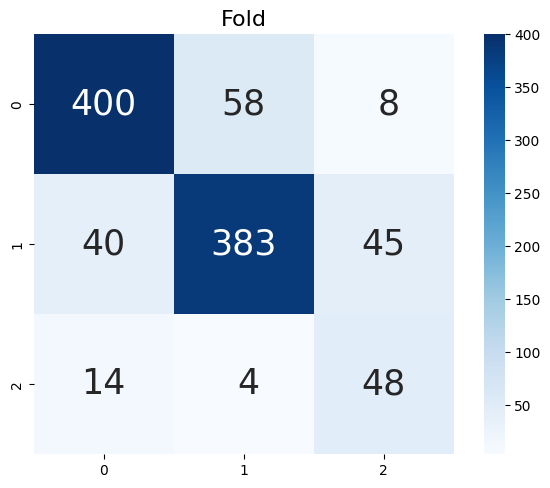

In [16]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(label, label_pre):
    cm_cst_nb = confusion_matrix(label,label_pre)
    plt.figure(figsize=(17,12))
    # plt.suptitle('Confusion Matrix: XLM-R ', fontsize=20)

    plt.subplot(2,2,1)
    plt.title('Fold', fontsize=16)
    df_cm_cst_nb = pd.DataFrame(cm_cst_nb)#, index=np.unique(cst_train), columns=np.unique(cst_test))
    sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues')
        # print(classification_report(y_label, pred, digits = 4))
    print('Evaluation result:\n')
    print(classification_report(label, label_pre,digits=4))
get_metrics(data['verdict'], data['predicted_verdict'])

In [17]:
data['context_passage'] = data['context'].apply(preprocess_text)

In [18]:
import numpy as np

In [19]:
def predict_verdict(list_passage, claim):

    predicted_verdict = np.zeros((1,3))
    for passage in list_passage:
        input_ids = tokenizer.encode(passage, claim, return_tensors='pt')
        logits = nli_model(input_ids)[0]

        #0: contradiction, 1: neutral, 2: entailment
        probs = logits.softmax(dim=1).detach().cpu().numpy()
        predicted_verdict = np.concatenate((predicted_verdict, probs*100), axis = 0)

    #print(predicted_verdict)
    temp_rank = list(predicted_verdict.reshape(-1))
    temp_rank.sort(reverse = True)
    temp_threshold = temp_rank[len(list_passage)]
    #print(temp_threshold)
    predicted_verdict[:, 1] = 0


    if np.max(predicted_verdict).item() > temp_threshold: #có ít nhất 1 evidence sup, ref
        predicted_verdict = np.argmax(np.max(predicted_verdict, axis = 0))
    else:
        predicted_verdict = 1

    return predicted_verdict


In [ ]:
for i in range(20):
    print(i,'   ', predict_verdict(data['context_passage'][i], data['claim'][i]), data['verdict'][i])

0     0 0
1     1 1
2     0 0
3     2 1
4     1 0
5     1 1
6     0 0
7     0 0
8     1 1
9     0 1
10     1 1
11     0 0
12     2 1
13     0 0
14     0 1
15     0 1
16     2 2
17     1 1
18     0 0
19     2 2


In [20]:
data['predicted_verdict'] = data.apply(lambda row: predict_verdict(row['context_passage'], row['claim']), axis=1)

Evaluation result:

              precision    recall  f1-score   support

           0     0.7477    0.8777    0.8075       466
           1     0.8651    0.5342    0.6605       468
           2     0.3171    0.7879    0.4522        66

    accuracy                         0.7110      1000
   macro avg     0.6433    0.7332    0.6401      1000
weighted avg     0.7742    0.7110    0.7153      1000



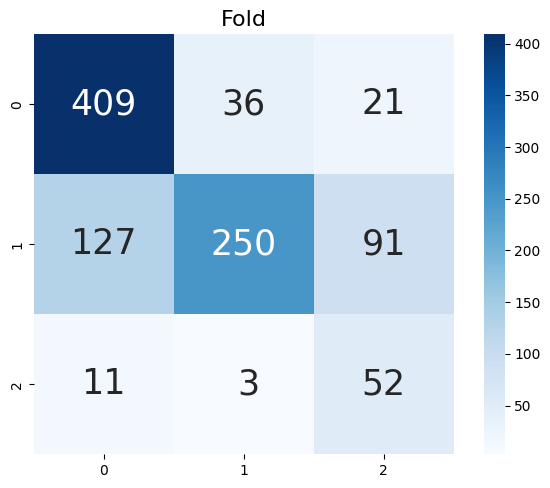

In [21]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(label, label_pre):
    cm_cst_nb = confusion_matrix(label,label_pre)
    plt.figure(figsize=(17,12))
    # plt.suptitle('Confusion Matrix: XLM-R ', fontsize=20)

    plt.subplot(2,2,1)
    plt.title('Fold', fontsize=16)
    df_cm_cst_nb = pd.DataFrame(cm_cst_nb)#, index=np.unique(cst_train), columns=np.unique(cst_test))
    sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues')
        # print(classification_report(y_label, pred, digits = 4))
    print('Evaluation result:\n')
    print(classification_report(label, label_pre,digits=4))
get_metrics(data['verdict'], data['predicted_verdict'])